# Results

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

# sns.reset_orig()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
def create_good_df(df):
    emptydf = pd.DataFrame(columns=list(df["Method"].unique()) + ["lastKDays"])
    emptydf

    for l, tempdf in df.groupby("lastKDays"):
        d = {}
        for method, tempdf1 in tempdf.groupby("Method"):
            d[method] = tempdf1["rmse"].mean()
    #     break
        temp = [d.get(col, np.nan) for col in emptydf.columns[:-1]]
        emptydf.loc[emptydf.shape[0]] = temp + [int(l)]

    emptydf['lastKDays'] = emptydf['lastKDays'].astype(int)
    emptydf = emptydf.set_index("lastKDays")
    emptydf = emptydf.rename(columns={"XGBRegressor": "XGB", "KNeighborsRegressor": "KNN"})
    try:
        emptydf.drop(columns=["XGBRFRegressor"], inplace=True)
    except KeyError:
        pass
#     emptydf = emptydf[['GPR', 'XGB', 'KNN','SVR', 'Lasso']]
    return emptydf

In [76]:
from common_functions import latexify, format_axes, tableau20blind
latexify(12, 8)
# latexify(columns=1)

In [77]:
params = {
    'lines.linewidth': 2,
    'lines.color': 'k',
#     'boxplot.boxprops.linewidth': 20,
    'boxplot.boxprops.color': 'k',
    'patch.linewidth': 3,
    'legend.fontsize': 14 + 6,
    'legend.framealpha': .6,
    'axes.titlesize': 14 + 6,
    "axes.labelsize": 14 + 6,
    'xtick.labelsize': 14 + 6,
    'ytick.labelsize': 16 + 6,
#     'axes.labelweight': 'bold',
    'axes.linewidth': 3,
#     'font.weight': 'bold'
    
}
matplotlib.rcParams.update(params)

## Beijing A

In [60]:
splits = 6

In [78]:
temp = []
for reg in ['las', 'knn', 'xgb', 'xgbRF', 'svr', 'gpST', 'gpFULL']:
    for loc in ["results", "lastK1"]:
        try:
            odf = pd.read_csv(f"../exp1/src/{loc}/beijinga_scaled/{reg}/final_test.csv")        
            new_temp = odf[odf["is_val_error"] == False]
            lastKDayss = new_temp['lastKDays'].unique()
            for lastKDays in lastKDayss:
                new_temp2 = new_temp[(new_temp['lastKDays'] == lastKDays) & (new_temp['time_ix'] >= lastKDays - 1)]
                new_temp3 = new_temp2[new_temp2["time_ix"] >= 29]
                temp.append(new_temp3)
        except Exception as e:
            print(e)
            pass
df = pd.concat(temp)
df.head()

[Errno 2] File b'../exp1/src/lastK1/beijinga_scaled/xgb/final_test.csv' does not exist: b'../exp1/src/lastK1/beijinga_scaled/xgb/final_test.csv'
[Errno 2] File b'../exp1/src/results/beijinga_scaled/xgbRF/final_test.csv' does not exist: b'../exp1/src/results/beijinga_scaled/xgbRF/final_test.csv'
[Errno 2] File b'../exp1/src/lastK1/beijinga_scaled/xgbRF/final_test.csv' does not exist: b'../exp1/src/lastK1/beijinga_scaled/xgbRF/final_test.csv'
[Errno 2] File b'../exp1/src/lastK1/beijinga_scaled/gpST/final_test.csv' does not exist: b'../exp1/src/lastK1/beijinga_scaled/gpST/final_test.csv'
[Errno 2] File b'../exp1/src/results/beijinga_scaled/gpFULL/final_test.csv' does not exist: b'../exp1/src/results/beijinga_scaled/gpFULL/final_test.csv'
[Errno 2] File b'../exp1/src/lastK1/beijinga_scaled/gpFULL/final_test.csv' does not exist: b'../exp1/src/lastK1/beijinga_scaled/gpFULL/final_test.csv'


,is_val_error,reg,stepSize,lastKDays,kout,kin,time_ix,hy_ix,rmse,mae
10,False,Lasso,2,50,0,-1,49,3,17.307314,17.052199
11,False,Lasso,2,50,0,-1,51,0,27.572378,27.176047
12,False,Lasso,2,50,0,-1,53,2,8.492146,7.155122
13,False,Lasso,2,50,0,-1,55,1,59.347461,52.680319
14,False,Lasso,2,50,0,-1,57,2,36.033533,35.738314


In [79]:
temp = {
    "reg": [],
    "time_ix": [],
    "rmse": [],
    "mae": [],
    "kout": [],
}
for called_reg, reg in zip(['IDW', 'Kriging', 'Spatial GP'], ['idw', 'krig', 'spatial_gp']):
    df_rmse = pd.read_csv(f"../exp1/interpol_baselines/{reg}_rmse.csv").T
    df_mae = pd.read_csv(f"../exp1/interpol_baselines/{reg}_mae.csv").T
    for ix, row in enumerate(sorted(df_rmse.index)):
        if ix % 2 == 1:
            continue
        temp["reg"].extend([called_reg] * splits)
        temp["time_ix"].extend([ix] * splits)
        temp["rmse"].extend(list(df_rmse.loc[row][[i for i in range(splits)]]))
        temp["mae"].extend(list(df_mae.loc[row][[i for i in range(splits)]]))
        temp["kout"].extend(list(range(splits)))

values_total = len(temp["reg"])
temp["lastKDays"] = [1] * values_total
temp["is_val_error"] = [False] * values_total
temp["stepSize"] = [2] * values_total
temp["kin"] = [-1] * values_total
temp["kout"] = [-1] * values_total
temp["hy_ix"] = [-1] * values_total
for col in df.columns:
    temp[col]
interpols = pd.DataFrame(temp)[df.columns]
interpols = interpols[interpols["time_ix"] >= 29]
interpols.head()

,is_val_error,reg,stepSize,lastKDays,kout,kin,time_ix,hy_ix,rmse,mae
90,False,IDW,2,1,-1,-1,30,-1,3.816993,2.608293
91,False,IDW,2,1,-1,-1,30,-1,4.633654,3.803035
92,False,IDW,2,1,-1,-1,30,-1,4.545861,3.703393
93,False,IDW,2,1,-1,-1,30,-1,4.670935,3.797206
94,False,IDW,2,1,-1,-1,30,-1,3.534897,2.897158


In [80]:
df = df.append(interpols)
df.tail()

,is_val_error,reg,stepSize,lastKDays,kout,kin,time_ix,hy_ix,rmse,mae
3217,False,Spatial GP,2,1,-1,-1,356,-1,7.450887,5.665492
3218,False,Spatial GP,2,1,-1,-1,356,-1,9.368780,6.531100
3219,False,Spatial GP,2,1,-1,-1,356,-1,4.476387,3.711090
3220,False,Spatial GP,2,1,-1,-1,356,-1,3.331551,2.931952
3221,False,Spatial GP,2,1,-1,-1,356,-1,5.154004,3.739507


In [81]:
interpols["time_ix"].unique()

array([ 30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,  54,
        56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,  80,
        82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102, 104, 106,
       108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132,
       134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158,
       160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184,
       186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210,
       212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236,
       238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262,
       264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288,
       290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314,
       316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340,
       342, 344, 346, 348, 350, 352, 354, 356])

In [82]:
for nonex, wow in df.groupby(["lastKDays", "reg"]):
    if nonex[0] == 1:
        print(f'{nonex[1]}:')
        print(sorted(list(wow["time_ix"].unique())))

IDW:
[30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356]
KNeighborsRegressor:
[30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 11

In [83]:
# df = df[(df['reg'].isin(["GPR", "SVR", "KNeighborsRegressor", "XGBRegressor", "Lasso"]))  & (df['lastKDays'].isin([10, 20, 30, 50]))]
df = df.rename(columns={"reg": "Method"})
# df.head()

In [84]:
df["Method"].unique()

array(['Lasso', 'KNeighborsRegressor', 'XGBRegressor', 'SVR', 'GPR',
       'SVGP', 'IDW', 'Kriging', 'Spatial GP'], dtype=object)

In [85]:
emptydf = create_good_df(df)
emptydf

,Lasso,KNN,XGB,SVR,GPR,SVGP,IDW,Kriging,Spatial GP
lastKDays,,,,,,,,,
1,16.199408,15.386741,NaN,16.126510,NaN,NaN,16.790679,14.827234,16.35691
10,37.550407,36.151260,16.530471,35.464989,20.234332,NaN,NaN,NaN,NaN
20,43.520893,35.660300,16.590851,40.070962,16.796107,NaN,NaN,NaN,NaN
30,46.102314,35.657574,16.718684,43.620188,16.288170,NaN,NaN,NaN,NaN
50,50.446792,36.765857,17.587178,46.967750,18.677015,50.761396,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,55.813333,NaN,NaN,NaN
200,NaN,NaN,NaN,NaN,NaN,63.981932,NaN,NaN,NaN


/home/apoorv/Desktop/github/.env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


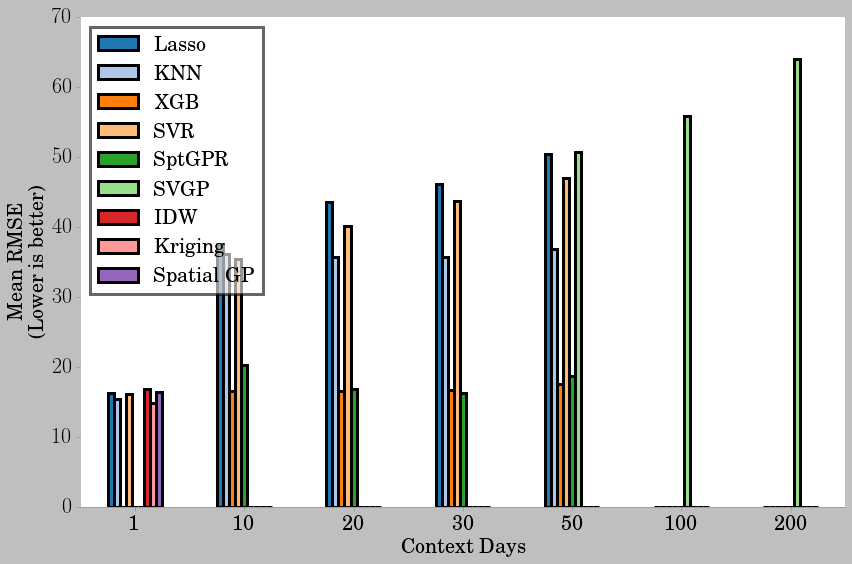

In [86]:
# plt.figure(figsize=(12, 8))
emptydf = emptydf.rename(columns={"GPR": "SptGPR"})
emptydf.plot(kind="bar",rot=0, colors=tableau20blind)
format_axes(plt.gca())
plt.ylabel("Mean RMSE\n(Lower is better)")
plt.xlabel("Context Days")
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("plts/lastK1/exp1a.pdf")
plt.show()

In [87]:
df.groupby(["lastKDays", "Method"]).mean()

is_val_error  stepSize      kout  kin  \
lastKDays Method                                                       
1         IDW                         False       2.0 -1.000000 -1.0   
          KNeighborsRegressor         False       2.0  2.500000 -1.0   
          Kriging                     False       2.0 -1.000000 -1.0   
          Lasso                       False       2.0  2.500000 -1.0   
          SVR                         False       2.0  2.500000 -1.0   
          Spatial GP                  False       2.0 -1.000000 -1.0   
10        GPR                         False       2.0  2.522655 -1.0   
          KNeighborsRegressor         False       2.0  2.500000 -1.0   
          Lasso                       False       2.0  2.500000 -1.0   
          SVR                         False       2.0  2.500000 -1.0   
          XGBRegressor                False       2.0  2.500000 -1.0   
20        GPR                         False       2.0  2.494565 -1.0   
          KNeighborsRegressor         False       2.0  2.500000 -1.0   
          Lasso                       False       2.0  2.500000 -1.0   
          SVR                         False       2.0  2.500000 -1.0   
          XGBRegressor                False       2.0  2.500000 -1.0   
30        GPR                         False       2.0  2.515385 -1.0   
          KNeighborsRegressor         False       2.0  2.500000 -1.0   
          Lasso                       False       2.0  2.500000 -1.0   
          SVR                         False       2.0  2.500000 -1.0   
          XGBRegressor                False       2.0  2.500000 -1.0   
50        GPR                         False       2.0  2.549941 -1.0   
          KNeighborsRegressor         False       2.0  2.500000 -1.0   
          Lasso                       False       2.0  2.500000 -1.0   
          SVGP                        False       2.0  2.500000 -1.0   
          SVR                         False       2.0  2.500000 -1.0   
          XGBRegressor                False       2.0  2.500000 -1.0   
100       SVGP                        False       2.0  2.500000 -1.0   
200       SVGP                        False       2.0  2.500000 -1.0   

                                  time_ix     hy_ix       rmse        mae  
lastKDays Method                                                           
1         IDW                  193.000000 -1.000000  16.790679  13.003668  
          KNeighborsRegressor  193.000000  2.337398  15.386741  11.973964  
          Kriging              193.000000 -1.000000  14.827234  11.537678  
          Lasso                193.000000  1.957317  16.199408  12.823304  
          SVR                  193.000000  3.893293  16.126510  12.354261  
          Spatial GP           193.000000 -1.000000  16.356910  12.607657  
10        GPR                  194.850369 -1.000000  20.234332  16.865000  
          KNeighborsRegressor  193.000000  3.020202  36.151260  32.160961  
          Lasso                193.000000  1.520202  37.550407  33.861817  
          SVR                  193.000000  4.150505  35.464989  31.510560  
          XGBRegressor         193.000000  4.567677  16.530471  12.826442  
20        GPR                  193.873913 -1.000000  16.796107  13.413240  
          KNeighborsRegressor  193.000000  3.087879  35.660300  31.503581  
          Lasso                193.000000  1.520202  43.520893  39.855778  
          SVR                  193.000000  3.907071  40.070962  36.154395  
          XGBRegressor         193.000000  4.927273  16.590851  12.827891  
30        GPR                  192.419780 -1.000000  16.288170  12.894913  
          KNeighborsRegressor  193.000000  3.066667  35.657574  31.501660  
          Lasso                193.000000  1.426263  46.102314  42.446780  
          SVR                  193.000000  3.688889  43.620188  39.738064  
          XGBRegressor         193.000000  5.075758  16.718684  12.983616  
50        GPR                  203.277321 -1.00000

## Beijing B

In [15]:
temp = []
for reg in ['las', 'knn', 'xgb', 'xgbRF', 'svr', 'gpST', 'gpFULL']:
    try:
        odf = pd.read_csv(f"../exp1/src/results/beijingb_scaled/{reg}/final_test.csv")        
        new_temp = odf[odf["is_val_error"] == False]
        lastKDayss = new_temp['lastKDays'].unique()
        for lastKDays in lastKDayss:
            temp.append(new_temp[(new_temp['lastKDays'] == lastKDays) & (new_temp['time_ix'] >= lastKDays - 1)])
    except Exception as e:
        print(e)
        pass
df = pd.concat(temp)
# df = df.append(interpols)
# df = df[~(df['reg'] == "SVGP") & ~(df['lastKDays'].isin([1, 100, 200]))]
df = df.rename(columns={"reg": "Method"})
emptydf = create_good_df(df)
emptydf

# plt.figure(figsize=(12, 8))
# sns.barplot(data=df, x = "lastKDays", y="rmse", hue="Method", errwidth=0)
# plt.ylabel("RMSE")
# plt.xlabel("Number of days used as context")
# plt.title(f"Average Test Performances Using Nested Cross Validation on Beijing B.")

[Errno 2] File b'../exp1/src/results/beijingb_scaled/xgbRF/final_test.csv' does not exist: b'../exp1/src/results/beijingb_scaled/xgbRF/final_test.csv'
[Errno 2] File b'../exp1/src/results/beijingb_scaled/gpST/final_test.csv' does not exist: b'../exp1/src/results/beijingb_scaled/gpST/final_test.csv'


,Lasso,KNN,XGB,SVR,GPR,SVGP
lastKDays,,,,,,
10,24.752700,20.608751,16.872090,21.940235,16.691106,NaN
20,27.375158,21.582612,16.969984,24.890892,16.253796,NaN
30,29.228556,21.704802,16.880813,25.969089,15.568837,NaN
50,30.902188,22.256076,17.653919,28.086230,16.619074,NaN
100,NaN,NaN,NaN,NaN,NaN,59.04528


<Figure size 864x576 with 0 Axes>

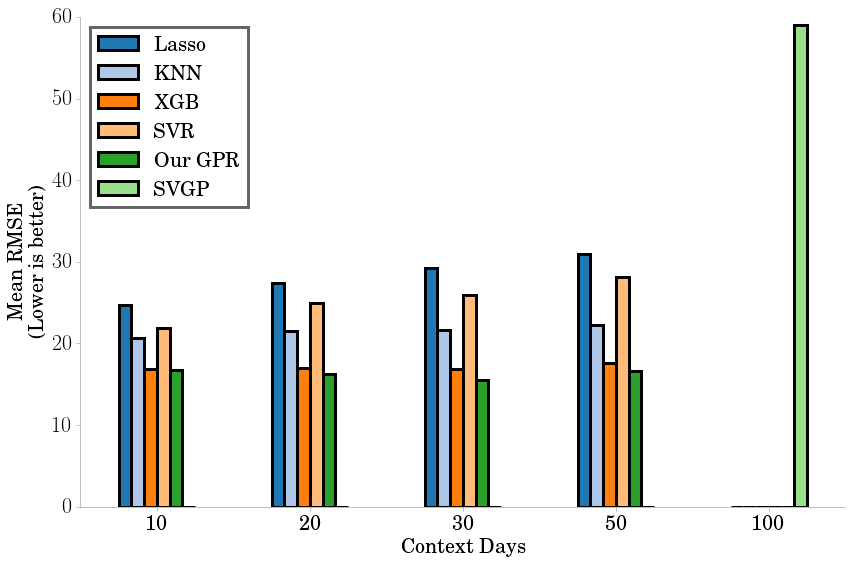

In [16]:
plt.figure(figsize=(12, 8))
emptydf = emptydf.rename(columns={"GPR": "Our GPR"})
emptydf.plot(kind="bar",rot=0)#, colors=tableau20blind)
format_axes(plt.gca())
plt.ylabel("Mean RMSE\n(Lower is better)")
plt.xlabel("Context Days")
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("plts/lastK1/exp1b.pdf")
plt.show()

In [17]:
df.groupby(["lastKDays", "Method",]).mean()

is_val_error  stepSize      kout  kin  \
lastKDays Method                                                       
10        GPR                         False       2.0  2.518947 -1.0   
          KNeighborsRegressor         False       2.0  2.500000 -1.0   
          Lasso                       False       2.0  2.500000 -1.0   
          SVR                         False       2.0  2.500000 -1.0   
          XGBRegressor                False       2.0  2.500000 -1.0   
20        GPR                         False       2.0  2.520879 -1.0   
          KNeighborsRegressor         False       2.0  2.500000 -1.0   
          Lasso                       False       2.0  2.500000 -1.0   
          SVR                         False       2.0  2.500000 -1.0   
          XGBRegressor                False       2.0  2.500000 -1.0   
30        GPR                         False       2.0  2.514739 -1.0   
          KNeighborsRegressor         False       2.0  2.500000 -1.0   
          Lasso                       False       2.0  2.500000 -1.0   
          SVR                         False       2.0  2.500000 -1.0   
          XGBRegressor                False       2.0  2.500000 -1.0   
50        GPR                         False       2.0  2.538835 -1.0   
          KNeighborsRegressor         False       2.0  2.500000 -1.0   
          Lasso                       False       2.0  2.500000 -1.0   
          SVR                         False       2.0  2.500000 -1.0   
          XGBRegressor                False       2.0  2.500000 -1.0   
100       SVGP                        False       2.0  2.500000 -1.0   

                                  time_ix     hy_ix       rmse        mae  
lastKDays Method                                                           
10        GPR                  194.345263 -1.000000  16.691106  13.144337  
          KNeighborsRegressor  193.000000  1.920202  20.608751  15.964686  
          Lasso                193.000000  2.081818  24.752700  20.312991  
          SVR                  193.000000  4.533333  21.940235  17.345463  
          XGBRegressor         193.000000  4.317172  16.872090  13.108308  
20        GPR                  191.942857 -1.000000  16.253796  12.679077  
          KNeighborsRegressor  193.000000  2.035354  21.582612  16.630938  
          Lasso                193.000000  1.881818  27.375158  22.880777  
          SVR                  193.000000  4.407071  24.890892  20.248025  
          XGBRegressor         193.000000  4.669697  16.969984  13.143421  
30        GPR                  190.324263 -1.000000  15.568837  12.313509  
          KNeighborsRegressor  193.000000  2.120202  21.704802  16.760842  
          Lasso                193.000000  1.994949  29.228556  24.558135  
          SVR                  193.000000  4.300000  25.969089  21.199320  
          XGBRegressor         193.000000  4.902020  16.880813  13.086529  
50        GPR                  200.388350 -1.000000  16.619074  13.216775  
          KNeighborsRegressor  203.000000  2.078495  22.256076  17.197684  
          Lasso                203.000000  1.963441  30.902188  26.107332  
          SVR                  203.000000  4.183871  28.086230  23.058433  
          XGBRegressor         203.000000  5.311828  17.653919  13.673872  
100       SVGP                 228.000000 -1.000000  59.045280  54.610688